In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : ['coords'],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 1000,
    'patience'      : 7,
    'dropout'       : 0.75,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_1000_075_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_1_coords_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(772408, 831)
(772408, 8)
validation
(101248, 831)
(101248, 8)
test
(98888, 831)
(98888, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 831)]             0         


 dense (Dense)               (None, 1024)              851968    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1542024 (5.88 MB)


Trainable params: 1542024 (5.88 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/773 [..............................] - ETA: 14:29 - loss: 1.6081 - STD: 0.1175 - MAE: 0.1839

 15/773 [..............................] - ETA: 2s - loss: 1.3703 - STD: 0.1921 - MAE: 0.1467   

 27/773 [>.............................] - ETA: 2s - loss: 1.3445 - STD: 0.1914 - MAE: 0.1461

 40/773 [>.............................] - ETA: 2s - loss: 1.3351 - STD: 0.1913 - MAE: 0.1460

 52/773 [=>............................] - ETA: 2s - loss: 1.3251 - STD: 0.1918 - MAE: 0.1454

 67/773 [=>............................] - ETA: 2s - loss: 1.3082 - STD: 0.1929 - MAE: 0.1443

 83/773 [==>...........................] - ETA: 2s - loss: 1.2904 - STD: 0.1941 - MAE: 0.1432

 99/773 [==>...........................] - ETA: 2s - loss: 1.2721 - STD: 0.1951 - MAE: 0.1423

113/773 [===>..........................] - ETA: 2s - loss: 1.2591 - STD: 0.1957 - MAE: 0.1417

130/773 [====>.........................] - ETA: 2s - loss: 1.2441 - STD: 0.1965 - MAE: 0.1408

146/773 [====>.........................] - ETA: 2s - loss: 1.2307 - STD: 0.1976 - MAE: 0.1400

162/773 [=====>........................] - ETA: 2s - loss: 1.2165 - STD: 0.1984 - MAE: 0.1393

178/773 [=====>........................] - ETA: 2s - loss: 1.2025 - STD: 0.1993 - MAE: 0.1385

195/773 [======>.......................] - ETA: 1s - loss: 1.1853 - STD: 0.2006 - MAE: 0.1373

211/773 [=======>......................] - ETA: 1s - loss: 1.1706 - STD: 0.2018 - MAE: 0.1362

216/773 [=======>......................] - ETA: 3s - loss: 1.1675 - STD: 0.2022 - MAE: 0.1359

231/773 [=======>......................] - ETA: 3s - loss: 1.1550 - STD: 0.2034 - MAE: 0.1349

247/773 [========>.....................] - ETA: 2s - loss: 1.1418 - STD: 0.2044 - MAE: 0.1340

263/773 [=========>....................] - ETA: 2s - loss: 1.1292 - STD: 0.2055 - MAE: 0.1331

279/773 [=========>....................] - ETA: 2s - loss: 1.1177 - STD: 0.2066 - MAE: 0.1322

295/773 [==========>...................] - ETA: 2s - loss: 1.1067 - STD: 0.2076 - MAE: 0.1313

311/773 [===========>..................] - ETA: 2s - loss: 1.0972 - STD: 0.2084 - MAE: 0.1306

328/773 [===========>..................] - ETA: 2s - loss: 1.0876 - STD: 0.2093 - MAE: 0.1299

345/773 [============>.................] - ETA: 2s - loss: 1.0780 - STD: 0.2102 - MAE: 0.1291

363/773 [=============>................] - ETA: 1s - loss: 1.0690 - STD: 0.2110 - MAE: 0.1284

380/773 [=============>................] - ETA: 1s - loss: 1.0603 - STD: 0.2118 - MAE: 0.1277

397/773 [==============>...............] - ETA: 1s - loss: 1.0525 - STD: 0.2125 - MAE: 0.1271

414/773 [===============>..............] - ETA: 1s - loss: 1.0451 - STD: 0.2132 - MAE: 0.1265

431/773 [===============>..............] - ETA: 1s - loss: 1.0382 - STD: 0.2139 - MAE: 0.1260

448/773 [================>.............] - ETA: 1s - loss: 1.0327 - STD: 0.2144 - MAE: 0.1255

465/773 [=================>............] - ETA: 1s - loss: 1.0275 - STD: 0.2149 - MAE: 0.1251

481/773 [=================>............] - ETA: 1s - loss: 1.0226 - STD: 0.2153 - MAE: 0.1248

498/773 [==================>...........] - ETA: 1s - loss: 1.0169 - STD: 0.2159 - MAE: 0.1243

515/773 [==================>...........] - ETA: 1s - loss: 1.0119 - STD: 0.2164 - MAE: 0.1239

531/773 [===================>..........] - ETA: 1s - loss: 1.0071 - STD: 0.2168 - MAE: 0.1235

546/773 [====================>.........] - ETA: 0s - loss: 1.0031 - STD: 0.2173 - MAE: 0.1231

561/773 [====================>.........] - ETA: 0s - loss: 0.9993 - STD: 0.2176 - MAE: 0.1228

578/773 [=====================>........] - ETA: 0s - loss: 0.9952 - STD: 0.2181 - MAE: 0.1225

594/773 [======================>.......] - ETA: 0s - loss: 0.9916 - STD: 0.2184 - MAE: 0.1222

612/773 [======================>.......] - ETA: 0s - loss: 0.9876 - STD: 0.2188 - MAE: 0.1218

629/773 [=======================>......] - ETA: 0s - loss: 0.9837 - STD: 0.2192 - MAE: 0.1215

646/773 [========================>.....] - ETA: 0s - loss: 0.9804 - STD: 0.2195 - MAE: 0.1212

663/773 [========================>.....] - ETA: 0s - loss: 0.9771 - STD: 0.2199 - MAE: 0.1209

680/773 [=========================>....] - ETA: 0s - loss: 0.9738 - STD: 0.2202 - MAE: 0.1207

697/773 [==========================>...] - ETA: 0s - loss: 0.9707 - STD: 0.2205 - MAE: 0.1204

712/773 [==========================>...] - ETA: 0s - loss: 0.9678 - STD: 0.2208 - MAE: 0.1201

730/773 [===========================>..] - ETA: 0s - loss: 0.9647 - STD: 0.2211 - MAE: 0.1199

744/773 [===========================>..] - ETA: 0s - loss: 0.9622 - STD: 0.2213 - MAE: 0.1197

760/773 [============================>.] - ETA: 0s - loss: 0.9599 - STD: 0.2216 - MAE: 0.1195

773/773 [==============================] - 5s 5ms/step - loss: 0.9576 - STD: 0.2218 - MAE: 0.1193 - val_loss: 0.8152 - val_STD: 0.2368 - val_MAE: 0.1045


Epoch 2/10000


  1/773 [..............................] - ETA: 19s - loss: 0.8557 - STD: 0.2342 - MAE: 0.1094

 14/773 [..............................] - ETA: 3s - loss: 0.8344 - STD: 0.2338 - MAE: 0.1089 

 27/773 [>.............................] - ETA: 2s - loss: 0.8351 - STD: 0.2338 - MAE: 0.1089

 44/773 [>.............................] - ETA: 2s - loss: 0.8346 - STD: 0.2339 - MAE: 0.1089

 61/773 [=>............................] - ETA: 2s - loss: 0.8297 - STD: 0.2346 - MAE: 0.1082

 75/773 [=>............................] - ETA: 2s - loss: 0.8290 - STD: 0.2347 - MAE: 0.1081

 90/773 [==>...........................] - ETA: 2s - loss: 0.8286 - STD: 0.2345 - MAE: 0.1082

107/773 [===>..........................] - ETA: 2s - loss: 0.8269 - STD: 0.2348 - MAE: 0.1080

124/773 [===>..........................] - ETA: 2s - loss: 0.8257 - STD: 0.2350 - MAE: 0.1079

139/773 [====>.........................] - ETA: 2s - loss: 0.8245 - STD: 0.2352 - MAE: 0.1077

151/773 [====>.........................] - ETA: 2s - loss: 0.8249 - STD: 0.2351 - MAE: 0.1078

167/773 [=====>........................] - ETA: 2s - loss: 0.8229 - STD: 0.2352 - MAE: 0.1077

183/773 [======>.......................] - ETA: 2s - loss: 0.8216 - STD: 0.2355 - MAE: 0.1075

198/773 [======>.......................] - ETA: 1s - loss: 0.8208 - STD: 0.2355 - MAE: 0.1074

211/773 [=======>......................] - ETA: 1s - loss: 0.8190 - STD: 0.2355 - MAE: 0.1073

223/773 [=======>......................] - ETA: 1s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1073

235/773 [========>.....................] - ETA: 1s - loss: 0.8185 - STD: 0.2356 - MAE: 0.1073

248/773 [========>.....................] - ETA: 1s - loss: 0.8172 - STD: 0.2357 - MAE: 0.1072

264/773 [=========>....................] - ETA: 1s - loss: 0.8165 - STD: 0.2358 - MAE: 0.1071

281/773 [=========>....................] - ETA: 1s - loss: 0.8156 - STD: 0.2359 - MAE: 0.1071

298/773 [==========>...................] - ETA: 1s - loss: 0.8146 - STD: 0.2360 - MAE: 0.1070

315/773 [===========>..................] - ETA: 1s - loss: 0.8137 - STD: 0.2360 - MAE: 0.1069

332/773 [===========>..................] - ETA: 1s - loss: 0.8128 - STD: 0.2360 - MAE: 0.1069

349/773 [============>.................] - ETA: 1s - loss: 0.8114 - STD: 0.2362 - MAE: 0.1068

366/773 [=============>................] - ETA: 1s - loss: 0.8109 - STD: 0.2363 - MAE: 0.1067

383/773 [=============>................] - ETA: 1s - loss: 0.8103 - STD: 0.2363 - MAE: 0.1067

399/773 [==============>...............] - ETA: 1s - loss: 0.8106 - STD: 0.2365 - MAE: 0.1066

416/773 [===============>..............] - ETA: 1s - loss: 0.8098 - STD: 0.2365 - MAE: 0.1066

433/773 [===============>..............] - ETA: 1s - loss: 0.8088 - STD: 0.2366 - MAE: 0.1065

450/773 [================>.............] - ETA: 1s - loss: 0.8076 - STD: 0.2367 - MAE: 0.1064

466/773 [=================>............] - ETA: 1s - loss: 0.8067 - STD: 0.2367 - MAE: 0.1063

481/773 [=================>............] - ETA: 0s - loss: 0.8056 - STD: 0.2368 - MAE: 0.1062

497/773 [==================>...........] - ETA: 0s - loss: 0.8048 - STD: 0.2369 - MAE: 0.1062

513/773 [==================>...........] - ETA: 0s - loss: 0.8037 - STD: 0.2370 - MAE: 0.1061

530/773 [===================>..........] - ETA: 0s - loss: 0.8028 - STD: 0.2371 - MAE: 0.1060

547/773 [====================>.........] - ETA: 0s - loss: 0.8020 - STD: 0.2372 - MAE: 0.1059

563/773 [====================>.........] - ETA: 0s - loss: 0.8011 - STD: 0.2373 - MAE: 0.1058

579/773 [=====================>........] - ETA: 0s - loss: 0.8011 - STD: 0.2373 - MAE: 0.1058

595/773 [======================>.......] - ETA: 0s - loss: 0.8002 - STD: 0.2374 - MAE: 0.1057

612/773 [======================>.......] - ETA: 0s - loss: 0.7991 - STD: 0.2375 - MAE: 0.1056

628/773 [=======================>......] - ETA: 0s - loss: 0.7984 - STD: 0.2376 - MAE: 0.1055

644/773 [=======================>......] - ETA: 0s - loss: 0.7977 - STD: 0.2376 - MAE: 0.1055

660/773 [========================>.....] - ETA: 0s - loss: 0.7968 - STD: 0.2377 - MAE: 0.1054

676/773 [=========================>....] - ETA: 0s - loss: 0.7962 - STD: 0.2378 - MAE: 0.1053

693/773 [=========================>....] - ETA: 0s - loss: 0.7956 - STD: 0.2378 - MAE: 0.1053

710/773 [==========================>...] - ETA: 0s - loss: 0.7958 - STD: 0.2378 - MAE: 0.1053

726/773 [===========================>..] - ETA: 0s - loss: 0.7954 - STD: 0.2379 - MAE: 0.1053

742/773 [===========================>..] - ETA: 0s - loss: 0.7946 - STD: 0.2379 - MAE: 0.1052

759/773 [============================>.] - ETA: 0s - loss: 0.7937 - STD: 0.2380 - MAE: 0.1051

773/773 [==============================] - 3s 4ms/step - loss: 0.7932 - STD: 0.2381 - MAE: 0.1051 - val_loss: 0.7668 - val_STD: 0.2381 - val_MAE: 0.1018


Epoch 3/10000


  1/773 [..............................] - ETA: 16s - loss: 0.7728 - STD: 0.2402 - MAE: 0.1027

 16/773 [..............................] - ETA: 2s - loss: 0.7667 - STD: 0.2412 - MAE: 0.1023 

 33/773 [>.............................] - ETA: 2s - loss: 0.7581 - STD: 0.2418 - MAE: 0.1014

 50/773 [>.............................] - ETA: 2s - loss: 0.7608 - STD: 0.2416 - MAE: 0.1018

 66/773 [=>............................] - ETA: 2s - loss: 0.7636 - STD: 0.2414 - MAE: 0.1020

 83/773 [==>...........................] - ETA: 2s - loss: 0.7609 - STD: 0.2416 - MAE: 0.1018

100/773 [==>...........................] - ETA: 2s - loss: 0.7602 - STD: 0.2416 - MAE: 0.1018

117/773 [===>..........................] - ETA: 2s - loss: 0.7599 - STD: 0.2415 - MAE: 0.1018

134/773 [====>.........................] - ETA: 1s - loss: 0.7589 - STD: 0.2414 - MAE: 0.1019

150/773 [====>.........................] - ETA: 1s - loss: 0.7613 - STD: 0.2414 - MAE: 0.1019

167/773 [=====>........................] - ETA: 1s - loss: 0.7617 - STD: 0.2414 - MAE: 0.1020

183/773 [======>.......................] - ETA: 1s - loss: 0.7616 - STD: 0.2415 - MAE: 0.1019

199/773 [======>.......................] - ETA: 1s - loss: 0.7597 - STD: 0.2415 - MAE: 0.1018

216/773 [=======>......................] - ETA: 1s - loss: 0.7590 - STD: 0.2416 - MAE: 0.1018

232/773 [========>.....................] - ETA: 1s - loss: 0.7589 - STD: 0.2416 - MAE: 0.1018

249/773 [========>.....................] - ETA: 1s - loss: 0.7594 - STD: 0.2415 - MAE: 0.1019

265/773 [=========>....................] - ETA: 1s - loss: 0.7584 - STD: 0.2415 - MAE: 0.1018

281/773 [=========>....................] - ETA: 1s - loss: 0.7572 - STD: 0.2416 - MAE: 0.1017

298/773 [==========>...................] - ETA: 1s - loss: 0.7567 - STD: 0.2416 - MAE: 0.1017

313/773 [===========>..................] - ETA: 1s - loss: 0.7554 - STD: 0.2417 - MAE: 0.1016

329/773 [===========>..................] - ETA: 1s - loss: 0.7549 - STD: 0.2418 - MAE: 0.1015

344/773 [============>.................] - ETA: 1s - loss: 0.7544 - STD: 0.2419 - MAE: 0.1015

356/773 [============>.................] - ETA: 1s - loss: 0.7542 - STD: 0.2419 - MAE: 0.1014

371/773 [=============>................] - ETA: 1s - loss: 0.7543 - STD: 0.2419 - MAE: 0.1014

385/773 [=============>................] - ETA: 1s - loss: 0.7544 - STD: 0.2419 - MAE: 0.1014

398/773 [==============>...............] - ETA: 1s - loss: 0.7542 - STD: 0.2420 - MAE: 0.1014

410/773 [==============>...............] - ETA: 1s - loss: 0.7538 - STD: 0.2420 - MAE: 0.1014

423/773 [===============>..............] - ETA: 1s - loss: 0.7533 - STD: 0.2420 - MAE: 0.1014

439/773 [================>.............] - ETA: 1s - loss: 0.7525 - STD: 0.2421 - MAE: 0.1013

454/773 [================>.............] - ETA: 1s - loss: 0.7520 - STD: 0.2421 - MAE: 0.1012

469/773 [=================>............] - ETA: 1s - loss: 0.7513 - STD: 0.2422 - MAE: 0.1012

484/773 [=================>............] - ETA: 0s - loss: 0.7508 - STD: 0.2422 - MAE: 0.1011

496/773 [==================>...........] - ETA: 0s - loss: 0.7504 - STD: 0.2423 - MAE: 0.1011

508/773 [==================>...........] - ETA: 0s - loss: 0.7499 - STD: 0.2423 - MAE: 0.1011

522/773 [===================>..........] - ETA: 0s - loss: 0.7495 - STD: 0.2423 - MAE: 0.1010

540/773 [===================>..........] - ETA: 0s - loss: 0.7492 - STD: 0.2424 - MAE: 0.1010

556/773 [====================>.........] - ETA: 0s - loss: 0.7486 - STD: 0.2424 - MAE: 0.1009

573/773 [=====================>........] - ETA: 0s - loss: 0.7478 - STD: 0.2425 - MAE: 0.1008

591/773 [=====================>........] - ETA: 0s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1008

608/773 [======================>.......] - ETA: 0s - loss: 0.7471 - STD: 0.2426 - MAE: 0.1008

626/773 [=======================>......] - ETA: 0s - loss: 0.7466 - STD: 0.2427 - MAE: 0.1007

643/773 [=======================>......] - ETA: 0s - loss: 0.7463 - STD: 0.2427 - MAE: 0.1007

661/773 [========================>.....] - ETA: 0s - loss: 0.7459 - STD: 0.2427 - MAE: 0.1007

678/773 [=========================>....] - ETA: 0s - loss: 0.7456 - STD: 0.2428 - MAE: 0.1006

695/773 [=========================>....] - ETA: 0s - loss: 0.7451 - STD: 0.2428 - MAE: 0.1006

713/773 [==========================>...] - ETA: 0s - loss: 0.7449 - STD: 0.2428 - MAE: 0.1006

729/773 [===========================>..] - ETA: 0s - loss: 0.7448 - STD: 0.2429 - MAE: 0.1005

746/773 [===========================>..] - ETA: 0s - loss: 0.7448 - STD: 0.2429 - MAE: 0.1005

762/773 [============================>.] - ETA: 0s - loss: 0.7443 - STD: 0.2429 - MAE: 0.1005

773/773 [==============================] - 3s 4ms/step - loss: 0.7442 - STD: 0.2429 - MAE: 0.1005 - val_loss: 0.7774 - val_STD: 0.2415 - val_MAE: 0.1009


Epoch 4/10000


  1/773 [..............................] - ETA: 15s - loss: 0.7279 - STD: 0.2398 - MAE: 0.1017

 16/773 [..............................] - ETA: 2s - loss: 0.7350 - STD: 0.2441 - MAE: 0.0995 

 32/773 [>.............................] - ETA: 2s - loss: 0.7320 - STD: 0.2449 - MAE: 0.0990

 45/773 [>.............................] - ETA: 2s - loss: 0.7279 - STD: 0.2446 - MAE: 0.0989

 58/773 [=>............................] - ETA: 2s - loss: 0.7271 - STD: 0.2445 - MAE: 0.0990

 74/773 [=>............................] - ETA: 2s - loss: 0.7307 - STD: 0.2445 - MAE: 0.0991

 90/773 [==>...........................] - ETA: 2s - loss: 0.7305 - STD: 0.2446 - MAE: 0.0990

106/773 [===>..........................] - ETA: 2s - loss: 0.7287 - STD: 0.2448 - MAE: 0.0988

121/773 [===>..........................] - ETA: 2s - loss: 0.7275 - STD: 0.2447 - MAE: 0.0988

134/773 [====>.........................] - ETA: 2s - loss: 0.7284 - STD: 0.2447 - MAE: 0.0989

146/773 [====>.........................] - ETA: 2s - loss: 0.7297 - STD: 0.2446 - MAE: 0.0990

161/773 [=====>........................] - ETA: 2s - loss: 0.7315 - STD: 0.2446 - MAE: 0.0991

175/773 [=====>........................] - ETA: 2s - loss: 0.7318 - STD: 0.2445 - MAE: 0.0991

188/773 [======>.......................] - ETA: 2s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0991

203/773 [======>.......................] - ETA: 2s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0990

215/773 [=======>......................] - ETA: 2s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0991

227/773 [=======>......................] - ETA: 2s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0991

240/773 [========>.....................] - ETA: 1s - loss: 0.7313 - STD: 0.2446 - MAE: 0.0991

256/773 [========>.....................] - ETA: 1s - loss: 0.7309 - STD: 0.2445 - MAE: 0.0991

269/773 [=========>....................] - ETA: 1s - loss: 0.7307 - STD: 0.2445 - MAE: 0.0991

282/773 [=========>....................] - ETA: 1s - loss: 0.7311 - STD: 0.2445 - MAE: 0.0991

296/773 [==========>...................] - ETA: 1s - loss: 0.7308 - STD: 0.2445 - MAE: 0.0991

312/773 [===========>..................] - ETA: 1s - loss: 0.7306 - STD: 0.2445 - MAE: 0.0991

328/773 [===========>..................] - ETA: 1s - loss: 0.7298 - STD: 0.2446 - MAE: 0.0990

344/773 [============>.................] - ETA: 1s - loss: 0.7292 - STD: 0.2446 - MAE: 0.0989

360/773 [============>.................] - ETA: 1s - loss: 0.7282 - STD: 0.2447 - MAE: 0.0989

377/773 [=============>................] - ETA: 1s - loss: 0.7274 - STD: 0.2448 - MAE: 0.0987

393/773 [==============>...............] - ETA: 1s - loss: 0.7265 - STD: 0.2449 - MAE: 0.0986

406/773 [==============>...............] - ETA: 1s - loss: 0.7265 - STD: 0.2449 - MAE: 0.0986

419/773 [===============>..............] - ETA: 1s - loss: 0.7261 - STD: 0.2450 - MAE: 0.0986

431/773 [===============>..............] - ETA: 1s - loss: 0.7260 - STD: 0.2449 - MAE: 0.0986

444/773 [================>.............] - ETA: 1s - loss: 0.7252 - STD: 0.2450 - MAE: 0.0986

457/773 [================>.............] - ETA: 1s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0985

470/773 [=================>............] - ETA: 1s - loss: 0.7244 - STD: 0.2451 - MAE: 0.0985

484/773 [=================>............] - ETA: 1s - loss: 0.7245 - STD: 0.2451 - MAE: 0.0985

498/773 [==================>...........] - ETA: 1s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0985

510/773 [==================>...........] - ETA: 0s - loss: 0.7241 - STD: 0.2451 - MAE: 0.0985

522/773 [===================>..........] - ETA: 0s - loss: 0.7243 - STD: 0.2451 - MAE: 0.0985

535/773 [===================>..........] - ETA: 0s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0985

548/773 [====================>.........] - ETA: 0s - loss: 0.7247 - STD: 0.2451 - MAE: 0.0985

564/773 [====================>.........] - ETA: 0s - loss: 0.7246 - STD: 0.2451 - MAE: 0.0985

580/773 [=====================>........] - ETA: 0s - loss: 0.7236 - STD: 0.2451 - MAE: 0.0984

596/773 [======================>.......] - ETA: 0s - loss: 0.7229 - STD: 0.2452 - MAE: 0.0983

611/773 [======================>.......] - ETA: 0s - loss: 0.7227 - STD: 0.2452 - MAE: 0.0983

626/773 [=======================>......] - ETA: 0s - loss: 0.7227 - STD: 0.2453 - MAE: 0.0983

641/773 [=======================>......] - ETA: 0s - loss: 0.7228 - STD: 0.2452 - MAE: 0.0983

657/773 [========================>.....] - ETA: 0s - loss: 0.7220 - STD: 0.2453 - MAE: 0.0982

673/773 [=========================>....] - ETA: 0s - loss: 0.7217 - STD: 0.2453 - MAE: 0.0982

687/773 [=========================>....] - ETA: 0s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0982

703/773 [==========================>...] - ETA: 0s - loss: 0.7211 - STD: 0.2454 - MAE: 0.0982

718/773 [==========================>...] - ETA: 0s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0982

731/773 [===========================>..] - ETA: 0s - loss: 0.7207 - STD: 0.2454 - MAE: 0.0981

746/773 [===========================>..] - ETA: 0s - loss: 0.7203 - STD: 0.2454 - MAE: 0.0981

762/773 [============================>.] - ETA: 0s - loss: 0.7201 - STD: 0.2454 - MAE: 0.0981

773/773 [==============================] - 3s 4ms/step - loss: 0.7199 - STD: 0.2455 - MAE: 0.0981 - val_loss: 0.7636 - val_STD: 0.2462 - val_MAE: 0.0978


Epoch 5/10000


  1/773 [..............................] - ETA: 15s - loss: 0.7033 - STD: 0.2470 - MAE: 0.0959

 17/773 [..............................] - ETA: 2s - loss: 0.7058 - STD: 0.2483 - MAE: 0.0958 

 34/773 [>.............................] - ETA: 2s - loss: 0.6983 - STD: 0.2473 - MAE: 0.0960

 51/773 [>.............................] - ETA: 2s - loss: 0.6977 - STD: 0.2469 - MAE: 0.0962

 68/773 [=>............................] - ETA: 2s - loss: 0.7007 - STD: 0.2467 - MAE: 0.0965

 84/773 [==>...........................] - ETA: 2s - loss: 0.7004 - STD: 0.2468 - MAE: 0.0964

102/773 [==>...........................] - ETA: 2s - loss: 0.7008 - STD: 0.2468 - MAE: 0.0964

120/773 [===>..........................] - ETA: 1s - loss: 0.6980 - STD: 0.2473 - MAE: 0.0960

137/773 [====>.........................] - ETA: 1s - loss: 0.6962 - STD: 0.2475 - MAE: 0.0958

154/773 [====>.........................] - ETA: 1s - loss: 0.6956 - STD: 0.2477 - MAE: 0.0957

171/773 [=====>........................] - ETA: 1s - loss: 0.6946 - STD: 0.2477 - MAE: 0.0956

188/773 [======>.......................] - ETA: 1s - loss: 0.6940 - STD: 0.2478 - MAE: 0.0956

204/773 [======>.......................] - ETA: 1s - loss: 0.6934 - STD: 0.2479 - MAE: 0.0955

220/773 [=======>......................] - ETA: 1s - loss: 0.6928 - STD: 0.2480 - MAE: 0.0954

236/773 [========>.....................] - ETA: 1s - loss: 0.6936 - STD: 0.2480 - MAE: 0.0954

252/773 [========>.....................] - ETA: 1s - loss: 0.6949 - STD: 0.2479 - MAE: 0.0955

269/773 [=========>....................] - ETA: 1s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0955

286/773 [==========>...................] - ETA: 1s - loss: 0.6951 - STD: 0.2479 - MAE: 0.0955

304/773 [==========>...................] - ETA: 1s - loss: 0.6951 - STD: 0.2479 - MAE: 0.0956

323/773 [===========>..................] - ETA: 1s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0956

340/773 [============>.................] - ETA: 1s - loss: 0.6957 - STD: 0.2479 - MAE: 0.0956

357/773 [============>.................] - ETA: 1s - loss: 0.6958 - STD: 0.2479 - MAE: 0.0956

374/773 [=============>................] - ETA: 1s - loss: 0.6959 - STD: 0.2479 - MAE: 0.0956

391/773 [==============>...............] - ETA: 1s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0956

406/773 [==============>...............] - ETA: 1s - loss: 0.6955 - STD: 0.2479 - MAE: 0.0956

422/773 [===============>..............] - ETA: 1s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0956

438/773 [===============>..............] - ETA: 1s - loss: 0.6956 - STD: 0.2479 - MAE: 0.0956

455/773 [================>.............] - ETA: 0s - loss: 0.6953 - STD: 0.2479 - MAE: 0.0956

469/773 [=================>............] - ETA: 0s - loss: 0.6948 - STD: 0.2480 - MAE: 0.0955

483/773 [=================>............] - ETA: 0s - loss: 0.6950 - STD: 0.2480 - MAE: 0.0955

497/773 [==================>...........] - ETA: 0s - loss: 0.6953 - STD: 0.2480 - MAE: 0.0956

509/773 [==================>...........] - ETA: 0s - loss: 0.6953 - STD: 0.2480 - MAE: 0.0956

522/773 [===================>..........] - ETA: 0s - loss: 0.6953 - STD: 0.2480 - MAE: 0.0956

535/773 [===================>..........] - ETA: 0s - loss: 0.6948 - STD: 0.2480 - MAE: 0.0955

551/773 [====================>.........] - ETA: 0s - loss: 0.6949 - STD: 0.2480 - MAE: 0.0955

568/773 [=====================>........] - ETA: 0s - loss: 0.6947 - STD: 0.2481 - MAE: 0.0955

585/773 [=====================>........] - ETA: 0s - loss: 0.6945 - STD: 0.2480 - MAE: 0.0955

602/773 [======================>.......] - ETA: 0s - loss: 0.6941 - STD: 0.2480 - MAE: 0.0955

618/773 [======================>.......] - ETA: 0s - loss: 0.6942 - STD: 0.2481 - MAE: 0.0955

632/773 [=======================>......] - ETA: 0s - loss: 0.6938 - STD: 0.2481 - MAE: 0.0954

649/773 [========================>.....] - ETA: 0s - loss: 0.6937 - STD: 0.2481 - MAE: 0.0954

666/773 [========================>.....] - ETA: 0s - loss: 0.6937 - STD: 0.2481 - MAE: 0.0954

684/773 [=========================>....] - ETA: 0s - loss: 0.6934 - STD: 0.2481 - MAE: 0.0954

702/773 [==========================>...] - ETA: 0s - loss: 0.6931 - STD: 0.2482 - MAE: 0.0954

720/773 [==========================>...] - ETA: 0s - loss: 0.6927 - STD: 0.2482 - MAE: 0.0953

737/773 [===========================>..] - ETA: 0s - loss: 0.6924 - STD: 0.2482 - MAE: 0.0953

755/773 [============================>.] - ETA: 0s - loss: 0.6923 - STD: 0.2483 - MAE: 0.0953

771/773 [============================>.] - ETA: 0s - loss: 0.6922 - STD: 0.2483 - MAE: 0.0953

773/773 [==============================] - 3s 3ms/step - loss: 0.6923 - STD: 0.2483 - MAE: 0.0953 - val_loss: 0.7173 - val_STD: 0.2500 - val_MAE: 0.0941


Epoch 6/10000


  1/773 [..............................] - ETA: 14s - loss: 0.7493 - STD: 0.2482 - MAE: 0.0992

 18/773 [..............................] - ETA: 2s - loss: 0.7021 - STD: 0.2478 - MAE: 0.0960 

 35/773 [>.............................] - ETA: 2s - loss: 0.6905 - STD: 0.2485 - MAE: 0.0951

 53/773 [=>............................] - ETA: 2s - loss: 0.6865 - STD: 0.2490 - MAE: 0.0945

 71/773 [=>............................] - ETA: 2s - loss: 0.6851 - STD: 0.2487 - MAE: 0.0946

 89/773 [==>...........................] - ETA: 2s - loss: 0.6846 - STD: 0.2487 - MAE: 0.0946

106/773 [===>..........................] - ETA: 1s - loss: 0.6824 - STD: 0.2492 - MAE: 0.0942

123/773 [===>..........................] - ETA: 1s - loss: 0.6833 - STD: 0.2492 - MAE: 0.0943

140/773 [====>.........................] - ETA: 1s - loss: 0.6829 - STD: 0.2492 - MAE: 0.0942

155/773 [=====>........................] - ETA: 1s - loss: 0.6829 - STD: 0.2492 - MAE: 0.0943

172/773 [=====>........................] - ETA: 1s - loss: 0.6821 - STD: 0.2492 - MAE: 0.0942

190/773 [======>.......................] - ETA: 1s - loss: 0.6800 - STD: 0.2495 - MAE: 0.0940

206/773 [======>.......................] - ETA: 1s - loss: 0.6804 - STD: 0.2495 - MAE: 0.0940

221/773 [=======>......................] - ETA: 1s - loss: 0.6806 - STD: 0.2494 - MAE: 0.0940

233/773 [========>.....................] - ETA: 1s - loss: 0.6807 - STD: 0.2495 - MAE: 0.0940

247/773 [========>.....................] - ETA: 1s - loss: 0.6806 - STD: 0.2495 - MAE: 0.0940

264/773 [=========>....................] - ETA: 1s - loss: 0.6811 - STD: 0.2494 - MAE: 0.0941

281/773 [=========>....................] - ETA: 1s - loss: 0.6806 - STD: 0.2495 - MAE: 0.0940

298/773 [==========>...................] - ETA: 1s - loss: 0.6808 - STD: 0.2495 - MAE: 0.0940

314/773 [===========>..................] - ETA: 1s - loss: 0.6812 - STD: 0.2494 - MAE: 0.0941

330/773 [===========>..................] - ETA: 1s - loss: 0.6818 - STD: 0.2495 - MAE: 0.0941

344/773 [============>.................] - ETA: 1s - loss: 0.6825 - STD: 0.2494 - MAE: 0.0942

356/773 [============>.................] - ETA: 1s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0942

368/773 [=============>................] - ETA: 1s - loss: 0.6813 - STD: 0.2494 - MAE: 0.0941

380/773 [=============>................] - ETA: 1s - loss: 0.6810 - STD: 0.2495 - MAE: 0.0940

392/773 [==============>...............] - ETA: 1s - loss: 0.6809 - STD: 0.2495 - MAE: 0.0940

405/773 [==============>...............] - ETA: 1s - loss: 0.6811 - STD: 0.2495 - MAE: 0.0940

418/773 [===============>..............] - ETA: 1s - loss: 0.6809 - STD: 0.2495 - MAE: 0.0940

430/773 [===============>..............] - ETA: 1s - loss: 0.6806 - STD: 0.2495 - MAE: 0.0940

445/773 [================>.............] - ETA: 1s - loss: 0.6803 - STD: 0.2495 - MAE: 0.0940

457/773 [================>.............] - ETA: 1s - loss: 0.6798 - STD: 0.2496 - MAE: 0.0939

469/773 [=================>............] - ETA: 1s - loss: 0.6796 - STD: 0.2496 - MAE: 0.0939

481/773 [=================>............] - ETA: 1s - loss: 0.6791 - STD: 0.2496 - MAE: 0.0939

494/773 [==================>...........] - ETA: 0s - loss: 0.6791 - STD: 0.2497 - MAE: 0.0939

510/773 [==================>...........] - ETA: 0s - loss: 0.6786 - STD: 0.2497 - MAE: 0.0938

525/773 [===================>..........] - ETA: 0s - loss: 0.6781 - STD: 0.2497 - MAE: 0.0938

538/773 [===================>..........] - ETA: 0s - loss: 0.6779 - STD: 0.2498 - MAE: 0.0937

551/773 [====================>.........] - ETA: 0s - loss: 0.6775 - STD: 0.2498 - MAE: 0.0937

565/773 [====================>.........] - ETA: 0s - loss: 0.6775 - STD: 0.2498 - MAE: 0.0937

578/773 [=====================>........] - ETA: 0s - loss: 0.6773 - STD: 0.2499 - MAE: 0.0936

591/773 [=====================>........] - ETA: 0s - loss: 0.6773 - STD: 0.2499 - MAE: 0.0936

607/773 [======================>.......] - ETA: 0s - loss: 0.6773 - STD: 0.2499 - MAE: 0.0936

620/773 [=======================>......] - ETA: 0s - loss: 0.6775 - STD: 0.2499 - MAE: 0.0937

634/773 [=======================>......] - ETA: 0s - loss: 0.6772 - STD: 0.2499 - MAE: 0.0937

648/773 [========================>.....] - ETA: 0s - loss: 0.6768 - STD: 0.2499 - MAE: 0.0936

661/773 [========================>.....] - ETA: 0s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0936

675/773 [=========================>....] - ETA: 0s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0936

687/773 [=========================>....] - ETA: 0s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0936

700/773 [==========================>...] - ETA: 0s - loss: 0.6766 - STD: 0.2499 - MAE: 0.0936

713/773 [==========================>...] - ETA: 0s - loss: 0.6767 - STD: 0.2499 - MAE: 0.0936

727/773 [===========================>..] - ETA: 0s - loss: 0.6765 - STD: 0.2499 - MAE: 0.0936

740/773 [===========================>..] - ETA: 0s - loss: 0.6763 - STD: 0.2499 - MAE: 0.0936

753/773 [============================>.] - ETA: 0s - loss: 0.6761 - STD: 0.2500 - MAE: 0.0935

766/773 [============================>.] - ETA: 0s - loss: 0.6757 - STD: 0.2500 - MAE: 0.0935

773/773 [==============================] - 3s 4ms/step - loss: 0.6757 - STD: 0.2500 - MAE: 0.0935 - val_loss: 0.7411 - val_STD: 0.2475 - val_MAE: 0.0969


Epoch 7/10000


  1/773 [..............................] - ETA: 15s - loss: 0.6436 - STD: 0.2497 - MAE: 0.0923

 17/773 [..............................] - ETA: 2s - loss: 0.6642 - STD: 0.2511 - MAE: 0.0926 

 34/773 [>.............................] - ETA: 2s - loss: 0.6588 - STD: 0.2510 - MAE: 0.0922

 51/773 [>.............................] - ETA: 2s - loss: 0.6617 - STD: 0.2513 - MAE: 0.0922

 66/773 [=>............................] - ETA: 2s - loss: 0.6638 - STD: 0.2514 - MAE: 0.0922

 82/773 [==>...........................] - ETA: 2s - loss: 0.6633 - STD: 0.2512 - MAE: 0.0923

 98/773 [==>...........................] - ETA: 2s - loss: 0.6635 - STD: 0.2512 - MAE: 0.0923

115/773 [===>..........................] - ETA: 2s - loss: 0.6625 - STD: 0.2512 - MAE: 0.0922

131/773 [====>.........................] - ETA: 2s - loss: 0.6630 - STD: 0.2513 - MAE: 0.0922

147/773 [====>.........................] - ETA: 1s - loss: 0.6623 - STD: 0.2513 - MAE: 0.0921

163/773 [=====>........................] - ETA: 1s - loss: 0.6631 - STD: 0.2513 - MAE: 0.0922

179/773 [=====>........................] - ETA: 1s - loss: 0.6643 - STD: 0.2511 - MAE: 0.0924

196/773 [======>.......................] - ETA: 1s - loss: 0.6644 - STD: 0.2511 - MAE: 0.0924

213/773 [=======>......................] - ETA: 1s - loss: 0.6650 - STD: 0.2510 - MAE: 0.0924

229/773 [=======>......................] - ETA: 1s - loss: 0.6645 - STD: 0.2511 - MAE: 0.0923

247/773 [========>.....................] - ETA: 1s - loss: 0.6653 - STD: 0.2510 - MAE: 0.0924

263/773 [=========>....................] - ETA: 1s - loss: 0.6652 - STD: 0.2510 - MAE: 0.0924

276/773 [=========>....................] - ETA: 1s - loss: 0.6650 - STD: 0.2510 - MAE: 0.0924

289/773 [==========>...................] - ETA: 1s - loss: 0.6644 - STD: 0.2510 - MAE: 0.0924

306/773 [==========>...................] - ETA: 1s - loss: 0.6638 - STD: 0.2512 - MAE: 0.0923

323/773 [===========>..................] - ETA: 1s - loss: 0.6644 - STD: 0.2512 - MAE: 0.0923

339/773 [============>.................] - ETA: 1s - loss: 0.6651 - STD: 0.2512 - MAE: 0.0923

356/773 [============>.................] - ETA: 1s - loss: 0.6642 - STD: 0.2513 - MAE: 0.0922

373/773 [=============>................] - ETA: 1s - loss: 0.6638 - STD: 0.2513 - MAE: 0.0922

390/773 [==============>...............] - ETA: 1s - loss: 0.6630 - STD: 0.2513 - MAE: 0.0921

403/773 [==============>...............] - ETA: 1s - loss: 0.6631 - STD: 0.2514 - MAE: 0.0921

417/773 [===============>..............] - ETA: 1s - loss: 0.6628 - STD: 0.2514 - MAE: 0.0921

433/773 [===============>..............] - ETA: 1s - loss: 0.6622 - STD: 0.2515 - MAE: 0.0920

449/773 [================>.............] - ETA: 1s - loss: 0.6620 - STD: 0.2515 - MAE: 0.0920

465/773 [=================>............] - ETA: 0s - loss: 0.6614 - STD: 0.2515 - MAE: 0.0919

481/773 [=================>............] - ETA: 0s - loss: 0.6615 - STD: 0.2515 - MAE: 0.0920

495/773 [==================>...........] - ETA: 0s - loss: 0.6612 - STD: 0.2516 - MAE: 0.0919

510/773 [==================>...........] - ETA: 0s - loss: 0.6612 - STD: 0.2516 - MAE: 0.0919

528/773 [===================>..........] - ETA: 0s - loss: 0.6610 - STD: 0.2516 - MAE: 0.0919

546/773 [====================>.........] - ETA: 0s - loss: 0.6609 - STD: 0.2516 - MAE: 0.0919

564/773 [====================>.........] - ETA: 0s - loss: 0.6610 - STD: 0.2516 - MAE: 0.0919

581/773 [=====================>........] - ETA: 0s - loss: 0.6608 - STD: 0.2516 - MAE: 0.0919

598/773 [======================>.......] - ETA: 0s - loss: 0.6606 - STD: 0.2516 - MAE: 0.0919

615/773 [======================>.......] - ETA: 0s - loss: 0.6603 - STD: 0.2516 - MAE: 0.0919

632/773 [=======================>......] - ETA: 0s - loss: 0.6604 - STD: 0.2516 - MAE: 0.0919

649/773 [========================>.....] - ETA: 0s - loss: 0.6598 - STD: 0.2516 - MAE: 0.0918

666/773 [========================>.....] - ETA: 0s - loss: 0.6597 - STD: 0.2517 - MAE: 0.0918

683/773 [=========================>....] - ETA: 0s - loss: 0.6595 - STD: 0.2517 - MAE: 0.0918

699/773 [==========================>...] - ETA: 0s - loss: 0.6593 - STD: 0.2517 - MAE: 0.0918

717/773 [==========================>...] - ETA: 0s - loss: 0.6592 - STD: 0.2517 - MAE: 0.0917

732/773 [===========================>..] - ETA: 0s - loss: 0.6587 - STD: 0.2518 - MAE: 0.0917

746/773 [===========================>..] - ETA: 0s - loss: 0.6584 - STD: 0.2518 - MAE: 0.0916

758/773 [============================>.] - ETA: 0s - loss: 0.6580 - STD: 0.2518 - MAE: 0.0916

772/773 [============================>.] - ETA: 0s - loss: 0.6576 - STD: 0.2519 - MAE: 0.0916

773/773 [==============================] - 3s 3ms/step - loss: 0.6576 - STD: 0.2519 - MAE: 0.0916 - val_loss: 0.7575 - val_STD: 0.2544 - val_MAE: 0.0937


Epoch 8/10000


  1/773 [..............................] - ETA: 15s - loss: 0.7089 - STD: 0.2548 - MAE: 0.0935

 14/773 [..............................] - ETA: 2s - loss: 0.6381 - STD: 0.2559 - MAE: 0.0879 

 31/773 [>.............................] - ETA: 2s - loss: 0.6461 - STD: 0.2546 - MAE: 0.0892

 49/773 [>.............................] - ETA: 2s - loss: 0.6516 - STD: 0.2539 - MAE: 0.0900

 66/773 [=>............................] - ETA: 2s - loss: 0.6511 - STD: 0.2537 - MAE: 0.0902

 84/773 [==>...........................] - ETA: 2s - loss: 0.6508 - STD: 0.2533 - MAE: 0.0904

102/773 [==>...........................] - ETA: 2s - loss: 0.6513 - STD: 0.2531 - MAE: 0.0906

119/773 [===>..........................] - ETA: 1s - loss: 0.6517 - STD: 0.2532 - MAE: 0.0906

136/773 [====>.........................] - ETA: 1s - loss: 0.6510 - STD: 0.2532 - MAE: 0.0906

152/773 [====>.........................] - ETA: 1s - loss: 0.6512 - STD: 0.2530 - MAE: 0.0906

170/773 [=====>........................] - ETA: 1s - loss: 0.6505 - STD: 0.2530 - MAE: 0.0907

187/773 [======>.......................] - ETA: 1s - loss: 0.6510 - STD: 0.2530 - MAE: 0.0906

205/773 [======>.......................] - ETA: 1s - loss: 0.6503 - STD: 0.2530 - MAE: 0.0906

223/773 [=======>......................] - ETA: 1s - loss: 0.6501 - STD: 0.2531 - MAE: 0.0905

240/773 [========>.....................] - ETA: 1s - loss: 0.6490 - STD: 0.2531 - MAE: 0.0905

256/773 [========>.....................] - ETA: 1s - loss: 0.6491 - STD: 0.2531 - MAE: 0.0904

273/773 [=========>....................] - ETA: 1s - loss: 0.6492 - STD: 0.2531 - MAE: 0.0904

290/773 [==========>...................] - ETA: 1s - loss: 0.6509 - STD: 0.2530 - MAE: 0.0906

307/773 [==========>...................] - ETA: 1s - loss: 0.6506 - STD: 0.2529 - MAE: 0.0906

324/773 [===========>..................] - ETA: 1s - loss: 0.6504 - STD: 0.2529 - MAE: 0.0906

341/773 [============>.................] - ETA: 1s - loss: 0.6504 - STD: 0.2530 - MAE: 0.0906

359/773 [============>.................] - ETA: 1s - loss: 0.6502 - STD: 0.2529 - MAE: 0.0906

377/773 [=============>................] - ETA: 1s - loss: 0.6495 - STD: 0.2529 - MAE: 0.0906

395/773 [==============>...............] - ETA: 1s - loss: 0.6488 - STD: 0.2530 - MAE: 0.0905

412/773 [==============>...............] - ETA: 1s - loss: 0.6487 - STD: 0.2530 - MAE: 0.0905

428/773 [===============>..............] - ETA: 1s - loss: 0.6488 - STD: 0.2530 - MAE: 0.0905

444/773 [================>.............] - ETA: 0s - loss: 0.6482 - STD: 0.2530 - MAE: 0.0905

460/773 [================>.............] - ETA: 0s - loss: 0.6480 - STD: 0.2530 - MAE: 0.0905

476/773 [=================>............] - ETA: 0s - loss: 0.6477 - STD: 0.2531 - MAE: 0.0904

491/773 [==================>...........] - ETA: 0s - loss: 0.6477 - STD: 0.2531 - MAE: 0.0904

507/773 [==================>...........] - ETA: 0s - loss: 0.6480 - STD: 0.2531 - MAE: 0.0904

524/773 [===================>..........] - ETA: 0s - loss: 0.6482 - STD: 0.2531 - MAE: 0.0904

542/773 [====================>.........] - ETA: 0s - loss: 0.6483 - STD: 0.2531 - MAE: 0.0905

558/773 [====================>.........] - ETA: 0s - loss: 0.6484 - STD: 0.2530 - MAE: 0.0905

575/773 [=====================>........] - ETA: 0s - loss: 0.6484 - STD: 0.2531 - MAE: 0.0905

592/773 [=====================>........] - ETA: 0s - loss: 0.6484 - STD: 0.2530 - MAE: 0.0905

609/773 [======================>.......] - ETA: 0s - loss: 0.6480 - STD: 0.2531 - MAE: 0.0904

625/773 [=======================>......] - ETA: 0s - loss: 0.6478 - STD: 0.2531 - MAE: 0.0904

642/773 [=======================>......] - ETA: 0s - loss: 0.6477 - STD: 0.2531 - MAE: 0.0904

659/773 [========================>.....] - ETA: 0s - loss: 0.6471 - STD: 0.2531 - MAE: 0.0903

675/773 [=========================>....] - ETA: 0s - loss: 0.6465 - STD: 0.2532 - MAE: 0.0903

691/773 [=========================>....] - ETA: 0s - loss: 0.6460 - STD: 0.2532 - MAE: 0.0902

705/773 [==========================>...] - ETA: 0s - loss: 0.6457 - STD: 0.2532 - MAE: 0.0902

722/773 [===========================>..] - ETA: 0s - loss: 0.6458 - STD: 0.2533 - MAE: 0.0902

736/773 [===========================>..] - ETA: 0s - loss: 0.6462 - STD: 0.2533 - MAE: 0.0902

753/773 [============================>.] - ETA: 0s - loss: 0.6464 - STD: 0.2533 - MAE: 0.0902

770/773 [============================>.] - ETA: 0s - loss: 0.6460 - STD: 0.2533 - MAE: 0.0902

773/773 [==============================] - 3s 3ms/step - loss: 0.6459 - STD: 0.2533 - MAE: 0.0901 - val_loss: 0.7392 - val_STD: 0.2558 - val_MAE: 0.0920


Epoch 9/10000


  1/773 [..............................] - ETA: 21s - loss: 0.5921 - STD: 0.2601 - MAE: 0.0825

 13/773 [..............................] - ETA: 3s - loss: 0.6374 - STD: 0.2552 - MAE: 0.0887 

 26/773 [>.............................] - ETA: 3s - loss: 0.6342 - STD: 0.2549 - MAE: 0.0887

 39/773 [>.............................] - ETA: 2s - loss: 0.6337 - STD: 0.2545 - MAE: 0.0889

 55/773 [=>............................] - ETA: 2s - loss: 0.6351 - STD: 0.2545 - MAE: 0.0890

 71/773 [=>............................] - ETA: 2s - loss: 0.6369 - STD: 0.2543 - MAE: 0.0892

 88/773 [==>...........................] - ETA: 2s - loss: 0.6382 - STD: 0.2541 - MAE: 0.0894

101/773 [==>...........................] - ETA: 2s - loss: 0.6373 - STD: 0.2541 - MAE: 0.0893

113/773 [===>..........................] - ETA: 2s - loss: 0.6356 - STD: 0.2542 - MAE: 0.0892

125/773 [===>..........................] - ETA: 2s - loss: 0.6348 - STD: 0.2542 - MAE: 0.0892

138/773 [====>.........................] - ETA: 2s - loss: 0.6339 - STD: 0.2542 - MAE: 0.0891

152/773 [====>.........................] - ETA: 2s - loss: 0.6328 - STD: 0.2544 - MAE: 0.0889

165/773 [=====>........................] - ETA: 2s - loss: 0.6329 - STD: 0.2543 - MAE: 0.0890

177/773 [=====>........................] - ETA: 2s - loss: 0.6338 - STD: 0.2543 - MAE: 0.0890

192/773 [======>.......................] - ETA: 2s - loss: 0.6339 - STD: 0.2543 - MAE: 0.0890

209/773 [=======>......................] - ETA: 2s - loss: 0.6324 - STD: 0.2544 - MAE: 0.0889

223/773 [=======>......................] - ETA: 2s - loss: 0.6316 - STD: 0.2545 - MAE: 0.0888

236/773 [========>.....................] - ETA: 2s - loss: 0.6315 - STD: 0.2545 - MAE: 0.0888

250/773 [========>.....................] - ETA: 1s - loss: 0.6310 - STD: 0.2545 - MAE: 0.0887

265/773 [=========>....................] - ETA: 1s - loss: 0.6303 - STD: 0.2546 - MAE: 0.0887

279/773 [=========>....................] - ETA: 1s - loss: 0.6303 - STD: 0.2546 - MAE: 0.0887

296/773 [==========>...................] - ETA: 1s - loss: 0.6307 - STD: 0.2546 - MAE: 0.0887

313/773 [===========>..................] - ETA: 1s - loss: 0.6318 - STD: 0.2546 - MAE: 0.0887

329/773 [===========>..................] - ETA: 1s - loss: 0.6313 - STD: 0.2545 - MAE: 0.0887

345/773 [============>.................] - ETA: 1s - loss: 0.6311 - STD: 0.2546 - MAE: 0.0887

361/773 [=============>................] - ETA: 1s - loss: 0.6305 - STD: 0.2546 - MAE: 0.0886

377/773 [=============>................] - ETA: 1s - loss: 0.6311 - STD: 0.2547 - MAE: 0.0886

394/773 [==============>...............] - ETA: 1s - loss: 0.6307 - STD: 0.2547 - MAE: 0.0886

411/773 [==============>...............] - ETA: 1s - loss: 0.6307 - STD: 0.2547 - MAE: 0.0886

427/773 [===============>..............] - ETA: 1s - loss: 0.6305 - STD: 0.2547 - MAE: 0.0886

443/773 [================>.............] - ETA: 1s - loss: 0.6304 - STD: 0.2548 - MAE: 0.0885

459/773 [================>.............] - ETA: 1s - loss: 0.6306 - STD: 0.2548 - MAE: 0.0885

474/773 [=================>............] - ETA: 1s - loss: 0.6306 - STD: 0.2548 - MAE: 0.0885

491/773 [==================>...........] - ETA: 0s - loss: 0.6306 - STD: 0.2548 - MAE: 0.0885

507/773 [==================>...........] - ETA: 0s - loss: 0.6305 - STD: 0.2548 - MAE: 0.0885

523/773 [===================>..........] - ETA: 0s - loss: 0.6298 - STD: 0.2548 - MAE: 0.0885

539/773 [===================>..........] - ETA: 0s - loss: 0.6295 - STD: 0.2549 - MAE: 0.0884

556/773 [====================>.........] - ETA: 0s - loss: 0.6293 - STD: 0.2549 - MAE: 0.0884

570/773 [=====================>........] - ETA: 0s - loss: 0.6291 - STD: 0.2549 - MAE: 0.0884

584/773 [=====================>........] - ETA: 0s - loss: 0.6284 - STD: 0.2550 - MAE: 0.0883

597/773 [======================>.......] - ETA: 0s - loss: 0.6281 - STD: 0.2550 - MAE: 0.0883

609/773 [======================>.......] - ETA: 0s - loss: 0.6280 - STD: 0.2550 - MAE: 0.0883

623/773 [=======================>......] - ETA: 0s - loss: 0.6275 - STD: 0.2551 - MAE: 0.0882

635/773 [=======================>......] - ETA: 0s - loss: 0.6273 - STD: 0.2551 - MAE: 0.0882

648/773 [========================>.....] - ETA: 0s - loss: 0.6274 - STD: 0.2551 - MAE: 0.0882

661/773 [========================>.....] - ETA: 0s - loss: 0.6273 - STD: 0.2551 - MAE: 0.0881

673/773 [=========================>....] - ETA: 0s - loss: 0.6273 - STD: 0.2551 - MAE: 0.0881

685/773 [=========================>....] - ETA: 0s - loss: 0.6274 - STD: 0.2552 - MAE: 0.0881

699/773 [==========================>...] - ETA: 0s - loss: 0.6276 - STD: 0.2551 - MAE: 0.0882

712/773 [==========================>...] - ETA: 0s - loss: 0.6276 - STD: 0.2551 - MAE: 0.0882

724/773 [===========================>..] - ETA: 0s - loss: 0.6276 - STD: 0.2551 - MAE: 0.0882

738/773 [===========================>..] - ETA: 0s - loss: 0.6275 - STD: 0.2552 - MAE: 0.0881

751/773 [============================>.] - ETA: 0s - loss: 0.6274 - STD: 0.2552 - MAE: 0.0881

764/773 [============================>.] - ETA: 0s - loss: 0.6273 - STD: 0.2552 - MAE: 0.0881

773/773 [==============================] - 3s 4ms/step - loss: 0.6273 - STD: 0.2552 - MAE: 0.0881 - val_loss: 0.7727 - val_STD: 0.2477 - val_MAE: 0.0988


Epoch 10/10000


  1/773 [..............................] - ETA: 14s - loss: 0.6307 - STD: 0.2481 - MAE: 0.0922

 16/773 [..............................] - ETA: 2s - loss: 0.6090 - STD: 0.2566 - MAE: 0.0862 

 32/773 [>.............................] - ETA: 2s - loss: 0.6074 - STD: 0.2564 - MAE: 0.0862

 49/773 [>.............................] - ETA: 2s - loss: 0.6094 - STD: 0.2565 - MAE: 0.0863

 66/773 [=>............................] - ETA: 2s - loss: 0.6090 - STD: 0.2564 - MAE: 0.0863

 83/773 [==>...........................] - ETA: 2s - loss: 0.6113 - STD: 0.2564 - MAE: 0.0864

 99/773 [==>...........................] - ETA: 2s - loss: 0.6157 - STD: 0.2565 - MAE: 0.0867

115/773 [===>..........................] - ETA: 2s - loss: 0.6172 - STD: 0.2565 - MAE: 0.0867

132/773 [====>.........................] - ETA: 2s - loss: 0.6164 - STD: 0.2564 - MAE: 0.0867

149/773 [====>.........................] - ETA: 1s - loss: 0.6169 - STD: 0.2564 - MAE: 0.0868

165/773 [=====>........................] - ETA: 1s - loss: 0.6165 - STD: 0.2564 - MAE: 0.0867

182/773 [======>.......................] - ETA: 1s - loss: 0.6176 - STD: 0.2564 - MAE: 0.0869

199/773 [======>.......................] - ETA: 1s - loss: 0.6166 - STD: 0.2564 - MAE: 0.0867

215/773 [=======>......................] - ETA: 1s - loss: 0.6159 - STD: 0.2564 - MAE: 0.0867

232/773 [========>.....................] - ETA: 1s - loss: 0.6153 - STD: 0.2565 - MAE: 0.0867

249/773 [========>.....................] - ETA: 1s - loss: 0.6145 - STD: 0.2565 - MAE: 0.0866

266/773 [=========>....................] - ETA: 1s - loss: 0.6141 - STD: 0.2566 - MAE: 0.0865

282/773 [=========>....................] - ETA: 1s - loss: 0.6142 - STD: 0.2566 - MAE: 0.0865

299/773 [==========>...................] - ETA: 1s - loss: 0.6150 - STD: 0.2566 - MAE: 0.0866

315/773 [===========>..................] - ETA: 1s - loss: 0.6149 - STD: 0.2566 - MAE: 0.0866

331/773 [===========>..................] - ETA: 1s - loss: 0.6150 - STD: 0.2566 - MAE: 0.0866

347/773 [============>.................] - ETA: 1s - loss: 0.6143 - STD: 0.2566 - MAE: 0.0865

363/773 [=============>................] - ETA: 1s - loss: 0.6138 - STD: 0.2566 - MAE: 0.0865

379/773 [=============>................] - ETA: 1s - loss: 0.6136 - STD: 0.2566 - MAE: 0.0865

394/773 [==============>...............] - ETA: 1s - loss: 0.6138 - STD: 0.2566 - MAE: 0.0865

408/773 [==============>...............] - ETA: 1s - loss: 0.6137 - STD: 0.2566 - MAE: 0.0865

420/773 [===============>..............] - ETA: 1s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0865

432/773 [===============>..............] - ETA: 1s - loss: 0.6139 - STD: 0.2566 - MAE: 0.0865

444/773 [================>.............] - ETA: 1s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0866

456/773 [================>.............] - ETA: 1s - loss: 0.6140 - STD: 0.2566 - MAE: 0.0866

468/773 [=================>............] - ETA: 1s - loss: 0.6139 - STD: 0.2566 - MAE: 0.0865

483/773 [=================>............] - ETA: 0s - loss: 0.6137 - STD: 0.2566 - MAE: 0.0865

496/773 [==================>...........] - ETA: 0s - loss: 0.6136 - STD: 0.2566 - MAE: 0.0865

509/773 [==================>...........] - ETA: 0s - loss: 0.6134 - STD: 0.2567 - MAE: 0.0865

525/773 [===================>..........] - ETA: 0s - loss: 0.6134 - STD: 0.2567 - MAE: 0.0864

540/773 [===================>..........] - ETA: 0s - loss: 0.6131 - STD: 0.2567 - MAE: 0.0864

554/773 [====================>.........] - ETA: 0s - loss: 0.6124 - STD: 0.2568 - MAE: 0.0864

570/773 [=====================>........] - ETA: 0s - loss: 0.6123 - STD: 0.2568 - MAE: 0.0863

582/773 [=====================>........] - ETA: 0s - loss: 0.6122 - STD: 0.2568 - MAE: 0.0863

594/773 [======================>.......] - ETA: 0s - loss: 0.6121 - STD: 0.2568 - MAE: 0.0863

606/773 [======================>.......] - ETA: 0s - loss: 0.6120 - STD: 0.2568 - MAE: 0.0863

620/773 [=======================>......] - ETA: 0s - loss: 0.6121 - STD: 0.2569 - MAE: 0.0863

636/773 [=======================>......] - ETA: 0s - loss: 0.6117 - STD: 0.2568 - MAE: 0.0863

652/773 [========================>.....] - ETA: 0s - loss: 0.6121 - STD: 0.2569 - MAE: 0.0863

666/773 [========================>.....] - ETA: 0s - loss: 0.6124 - STD: 0.2569 - MAE: 0.0863

678/773 [=========================>....] - ETA: 0s - loss: 0.6124 - STD: 0.2569 - MAE: 0.0863

691/773 [=========================>....] - ETA: 0s - loss: 0.6125 - STD: 0.2569 - MAE: 0.0863

705/773 [==========================>...] - ETA: 0s - loss: 0.6124 - STD: 0.2569 - MAE: 0.0863

718/773 [==========================>...] - ETA: 0s - loss: 0.6121 - STD: 0.2569 - MAE: 0.0863

730/773 [===========================>..] - ETA: 0s - loss: 0.6120 - STD: 0.2569 - MAE: 0.0863

745/773 [===========================>..] - ETA: 0s - loss: 0.6117 - STD: 0.2569 - MAE: 0.0863

761/773 [============================>.] - ETA: 0s - loss: 0.6116 - STD: 0.2569 - MAE: 0.0862

773/773 [==============================] - 3s 4ms/step - loss: 0.6116 - STD: 0.2570 - MAE: 0.0862 - val_loss: 0.7475 - val_STD: 0.2591 - val_MAE: 0.0915


Epoch 11/10000


  1/773 [..............................] - ETA: 16s - loss: 0.6465 - STD: 0.2615 - MAE: 0.0851

 14/773 [..............................] - ETA: 3s - loss: 0.6126 - STD: 0.2573 - MAE: 0.0863 

 30/773 [>.............................] - ETA: 2s - loss: 0.6023 - STD: 0.2578 - MAE: 0.0853

 45/773 [>.............................] - ETA: 2s - loss: 0.6002 - STD: 0.2578 - MAE: 0.0850

 58/773 [=>............................] - ETA: 2s - loss: 0.6016 - STD: 0.2580 - MAE: 0.0850

 71/773 [=>............................] - ETA: 2s - loss: 0.6032 - STD: 0.2580 - MAE: 0.0851

 89/773 [==>...........................] - ETA: 2s - loss: 0.6010 - STD: 0.2580 - MAE: 0.0850

107/773 [===>..........................] - ETA: 2s - loss: 0.6035 - STD: 0.2579 - MAE: 0.0852

124/773 [===>..........................] - ETA: 2s - loss: 0.6022 - STD: 0.2579 - MAE: 0.0852

140/773 [====>.........................] - ETA: 2s - loss: 0.6024 - STD: 0.2579 - MAE: 0.0852

154/773 [====>.........................] - ETA: 2s - loss: 0.6036 - STD: 0.2579 - MAE: 0.0853

169/773 [=====>........................] - ETA: 2s - loss: 0.6031 - STD: 0.2579 - MAE: 0.0852

183/773 [======>.......................] - ETA: 2s - loss: 0.6041 - STD: 0.2579 - MAE: 0.0853

196/773 [======>.......................] - ETA: 2s - loss: 0.6035 - STD: 0.2579 - MAE: 0.0852

209/773 [=======>......................] - ETA: 1s - loss: 0.6033 - STD: 0.2580 - MAE: 0.0852

226/773 [=======>......................] - ETA: 1s - loss: 0.6038 - STD: 0.2579 - MAE: 0.0853

243/773 [========>.....................] - ETA: 1s - loss: 0.6030 - STD: 0.2579 - MAE: 0.0852

260/773 [=========>....................] - ETA: 1s - loss: 0.6017 - STD: 0.2580 - MAE: 0.0851

277/773 [=========>....................] - ETA: 1s - loss: 0.6011 - STD: 0.2580 - MAE: 0.0850

293/773 [==========>...................] - ETA: 1s - loss: 0.6000 - STD: 0.2581 - MAE: 0.0850

310/773 [===========>..................] - ETA: 1s - loss: 0.5997 - STD: 0.2581 - MAE: 0.0849

327/773 [===========>..................] - ETA: 1s - loss: 0.5993 - STD: 0.2582 - MAE: 0.0849

343/773 [============>.................] - ETA: 1s - loss: 0.5983 - STD: 0.2582 - MAE: 0.0848

356/773 [============>.................] - ETA: 1s - loss: 0.5978 - STD: 0.2583 - MAE: 0.0847

371/773 [=============>................] - ETA: 1s - loss: 0.5977 - STD: 0.2583 - MAE: 0.0847

388/773 [==============>...............] - ETA: 1s - loss: 0.5973 - STD: 0.2584 - MAE: 0.0846

405/773 [==============>...............] - ETA: 1s - loss: 0.5975 - STD: 0.2584 - MAE: 0.0846

418/773 [===============>..............] - ETA: 1s - loss: 0.5978 - STD: 0.2584 - MAE: 0.0846

431/773 [===============>..............] - ETA: 1s - loss: 0.5984 - STD: 0.2584 - MAE: 0.0847

443/773 [================>.............] - ETA: 1s - loss: 0.5982 - STD: 0.2584 - MAE: 0.0847

455/773 [================>.............] - ETA: 1s - loss: 0.5982 - STD: 0.2584 - MAE: 0.0847

467/773 [=================>............] - ETA: 1s - loss: 0.5977 - STD: 0.2584 - MAE: 0.0846

479/773 [=================>............] - ETA: 1s - loss: 0.5976 - STD: 0.2584 - MAE: 0.0846

494/773 [==================>...........] - ETA: 0s - loss: 0.5974 - STD: 0.2584 - MAE: 0.0846

510/773 [==================>...........] - ETA: 0s - loss: 0.5971 - STD: 0.2585 - MAE: 0.0845

527/773 [===================>..........] - ETA: 0s - loss: 0.5970 - STD: 0.2585 - MAE: 0.0845

543/773 [====================>.........] - ETA: 0s - loss: 0.5970 - STD: 0.2586 - MAE: 0.0845

561/773 [====================>.........] - ETA: 0s - loss: 0.5970 - STD: 0.2586 - MAE: 0.0845

578/773 [=====================>........] - ETA: 0s - loss: 0.5969 - STD: 0.2586 - MAE: 0.0845

595/773 [======================>.......] - ETA: 0s - loss: 0.5963 - STD: 0.2586 - MAE: 0.0844

613/773 [======================>.......] - ETA: 0s - loss: 0.5962 - STD: 0.2586 - MAE: 0.0844

630/773 [=======================>......] - ETA: 0s - loss: 0.5960 - STD: 0.2587 - MAE: 0.0844

646/773 [========================>.....] - ETA: 0s - loss: 0.5957 - STD: 0.2587 - MAE: 0.0843

659/773 [========================>.....] - ETA: 0s - loss: 0.5955 - STD: 0.2587 - MAE: 0.0843

670/773 [=========================>....] - ETA: 0s - loss: 0.5952 - STD: 0.2587 - MAE: 0.0843

683/773 [=========================>....] - ETA: 0s - loss: 0.5950 - STD: 0.2588 - MAE: 0.0842

696/773 [==========================>...] - ETA: 0s - loss: 0.5950 - STD: 0.2588 - MAE: 0.0842

711/773 [==========================>...] - ETA: 0s - loss: 0.5952 - STD: 0.2588 - MAE: 0.0842

725/773 [===========================>..] - ETA: 0s - loss: 0.5951 - STD: 0.2588 - MAE: 0.0842

738/773 [===========================>..] - ETA: 0s - loss: 0.5949 - STD: 0.2588 - MAE: 0.0842

751/773 [============================>.] - ETA: 0s - loss: 0.5949 - STD: 0.2588 - MAE: 0.0842

763/773 [============================>.] - ETA: 0s - loss: 0.5948 - STD: 0.2588 - MAE: 0.0842

773/773 [==============================] - 3s 4ms/step - loss: 0.5947 - STD: 0.2588 - MAE: 0.0842 - val_loss: 0.7589 - val_STD: 0.2544 - val_MAE: 0.0947


Epoch 12/10000


  1/773 [..............................] - ETA: 13s - loss: 0.6464 - STD: 0.2549 - MAE: 0.0894

 18/773 [..............................] - ETA: 2s - loss: 0.5752 - STD: 0.2603 - MAE: 0.0820 

 35/773 [>.............................] - ETA: 2s - loss: 0.5809 - STD: 0.2605 - MAE: 0.0823

 52/773 [=>............................] - ETA: 2s - loss: 0.5885 - STD: 0.2601 - MAE: 0.0831

 69/773 [=>............................] - ETA: 2s - loss: 0.5903 - STD: 0.2600 - MAE: 0.0832

 86/773 [==>...........................] - ETA: 2s - loss: 0.5913 - STD: 0.2597 - MAE: 0.0835

102/773 [==>...........................] - ETA: 2s - loss: 0.5893 - STD: 0.2599 - MAE: 0.0832

119/773 [===>..........................] - ETA: 2s - loss: 0.5920 - STD: 0.2597 - MAE: 0.0835

135/773 [====>.........................] - ETA: 1s - loss: 0.5913 - STD: 0.2598 - MAE: 0.0835

152/773 [====>.........................] - ETA: 1s - loss: 0.5903 - STD: 0.2597 - MAE: 0.0835

169/773 [=====>........................] - ETA: 1s - loss: 0.5897 - STD: 0.2597 - MAE: 0.0834

186/773 [======>.......................] - ETA: 1s - loss: 0.5885 - STD: 0.2597 - MAE: 0.0833

203/773 [======>.......................] - ETA: 1s - loss: 0.5868 - STD: 0.2599 - MAE: 0.0831

220/773 [=======>......................] - ETA: 1s - loss: 0.5866 - STD: 0.2600 - MAE: 0.0831

237/773 [========>.....................] - ETA: 1s - loss: 0.5859 - STD: 0.2600 - MAE: 0.0830

254/773 [========>.....................] - ETA: 1s - loss: 0.5858 - STD: 0.2600 - MAE: 0.0830

270/773 [=========>....................] - ETA: 1s - loss: 0.5853 - STD: 0.2601 - MAE: 0.0829

285/773 [==========>...................] - ETA: 1s - loss: 0.5854 - STD: 0.2601 - MAE: 0.0829

297/773 [==========>...................] - ETA: 1s - loss: 0.5853 - STD: 0.2601 - MAE: 0.0829

310/773 [===========>..................] - ETA: 1s - loss: 0.5850 - STD: 0.2601 - MAE: 0.0829

323/773 [===========>..................] - ETA: 1s - loss: 0.5845 - STD: 0.2601 - MAE: 0.0828

335/773 [============>.................] - ETA: 1s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0828

348/773 [============>.................] - ETA: 1s - loss: 0.5840 - STD: 0.2602 - MAE: 0.0828

365/773 [=============>................] - ETA: 1s - loss: 0.5839 - STD: 0.2602 - MAE: 0.0828

382/773 [=============>................] - ETA: 1s - loss: 0.5840 - STD: 0.2602 - MAE: 0.0828

395/773 [==============>...............] - ETA: 1s - loss: 0.5834 - STD: 0.2603 - MAE: 0.0827

407/773 [==============>...............] - ETA: 1s - loss: 0.5833 - STD: 0.2603 - MAE: 0.0827

420/773 [===============>..............] - ETA: 1s - loss: 0.5834 - STD: 0.2602 - MAE: 0.0827

437/773 [===============>..............] - ETA: 1s - loss: 0.5835 - STD: 0.2603 - MAE: 0.0827

451/773 [================>.............] - ETA: 1s - loss: 0.5831 - STD: 0.2603 - MAE: 0.0827

463/773 [================>.............] - ETA: 1s - loss: 0.5830 - STD: 0.2603 - MAE: 0.0827

475/773 [=================>............] - ETA: 1s - loss: 0.5831 - STD: 0.2603 - MAE: 0.0827

488/773 [=================>............] - ETA: 0s - loss: 0.5831 - STD: 0.2603 - MAE: 0.0827

500/773 [==================>...........] - ETA: 0s - loss: 0.5830 - STD: 0.2603 - MAE: 0.0827

515/773 [==================>...........] - ETA: 0s - loss: 0.5828 - STD: 0.2603 - MAE: 0.0827

532/773 [===================>..........] - ETA: 0s - loss: 0.5825 - STD: 0.2603 - MAE: 0.0826

548/773 [====================>.........] - ETA: 0s - loss: 0.5826 - STD: 0.2603 - MAE: 0.0826

561/773 [====================>.........] - ETA: 0s - loss: 0.5826 - STD: 0.2604 - MAE: 0.0826

573/773 [=====================>........] - ETA: 0s - loss: 0.5824 - STD: 0.2604 - MAE: 0.0826

585/773 [=====================>........] - ETA: 0s - loss: 0.5824 - STD: 0.2604 - MAE: 0.0826

600/773 [======================>.......] - ETA: 0s - loss: 0.5823 - STD: 0.2604 - MAE: 0.0826

616/773 [======================>.......] - ETA: 0s - loss: 0.5819 - STD: 0.2604 - MAE: 0.0826

630/773 [=======================>......] - ETA: 0s - loss: 0.5814 - STD: 0.2604 - MAE: 0.0825

643/773 [=======================>......] - ETA: 0s - loss: 0.5812 - STD: 0.2605 - MAE: 0.0825

655/773 [========================>.....] - ETA: 0s - loss: 0.5811 - STD: 0.2605 - MAE: 0.0825

670/773 [=========================>....] - ETA: 0s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0825

686/773 [=========================>....] - ETA: 0s - loss: 0.5816 - STD: 0.2605 - MAE: 0.0825

700/773 [==========================>...] - ETA: 0s - loss: 0.5815 - STD: 0.2605 - MAE: 0.0825

716/773 [==========================>...] - ETA: 0s - loss: 0.5817 - STD: 0.2605 - MAE: 0.0825

732/773 [===========================>..] - ETA: 0s - loss: 0.5816 - STD: 0.2605 - MAE: 0.0825

749/773 [============================>.] - ETA: 0s - loss: 0.5813 - STD: 0.2605 - MAE: 0.0825

765/773 [============================>.] - ETA: 0s - loss: 0.5809 - STD: 0.2605 - MAE: 0.0824

773/773 [==============================] - 3s 4ms/step - loss: 0.5807 - STD: 0.2606 - MAE: 0.0824 - val_loss: 0.7847 - val_STD: 0.2629 - val_MAE: 0.0903


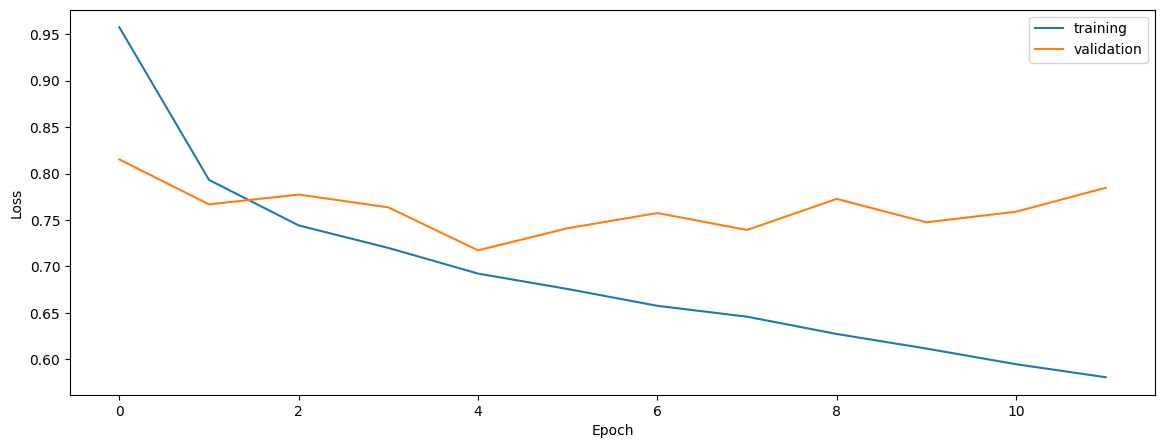

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.75772949983044
0.7486460791032445
0.7647160588030836


In [8]:
print('normalized')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

normalized


0.75772949983044
0.7486460791032445
0.7647160588030836


In [9]:
print('native')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

native


0.7544967069910893
0.7601493945078418
0.7626611018673596


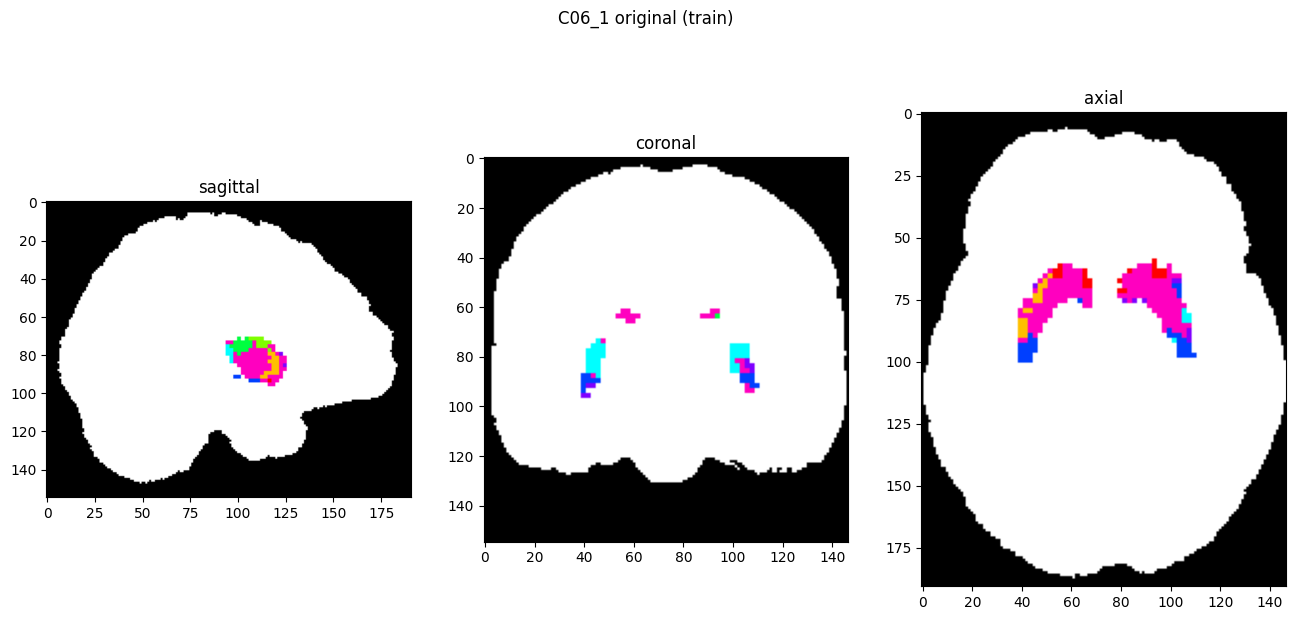

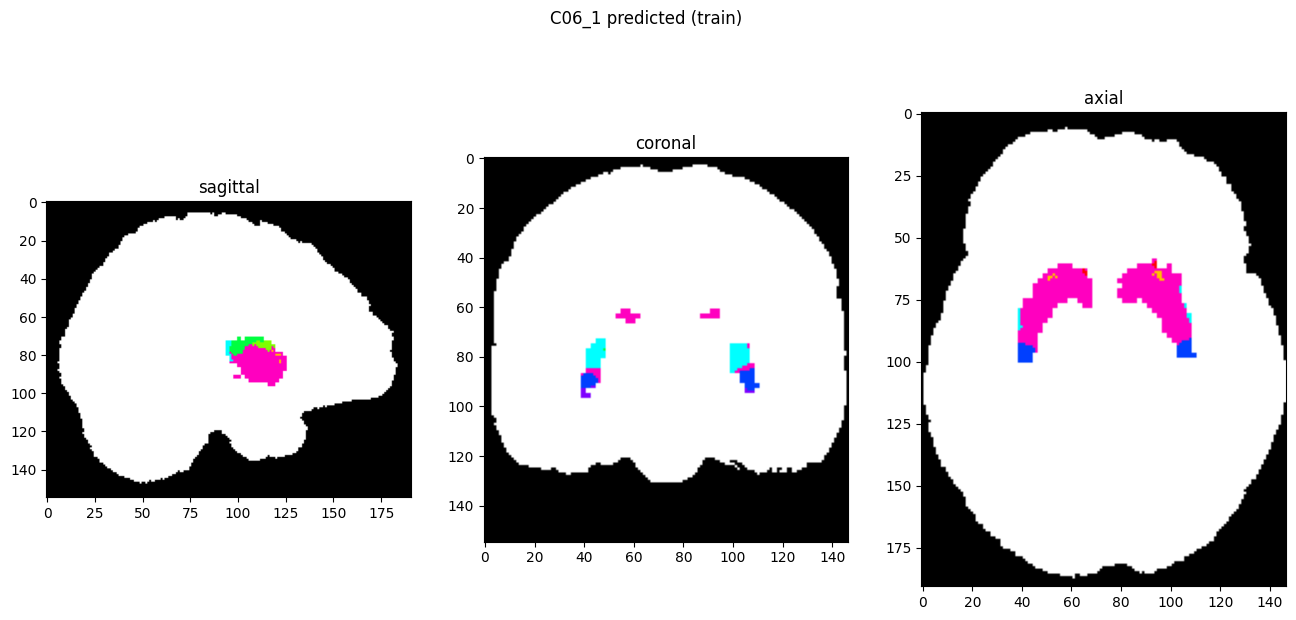

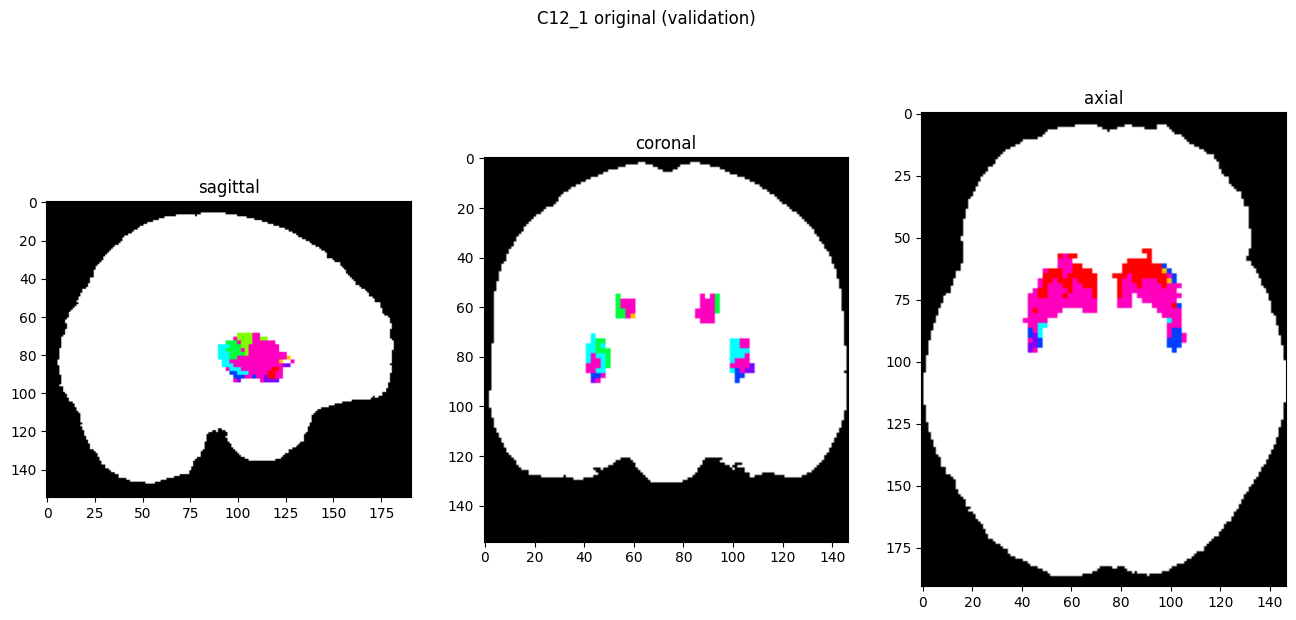

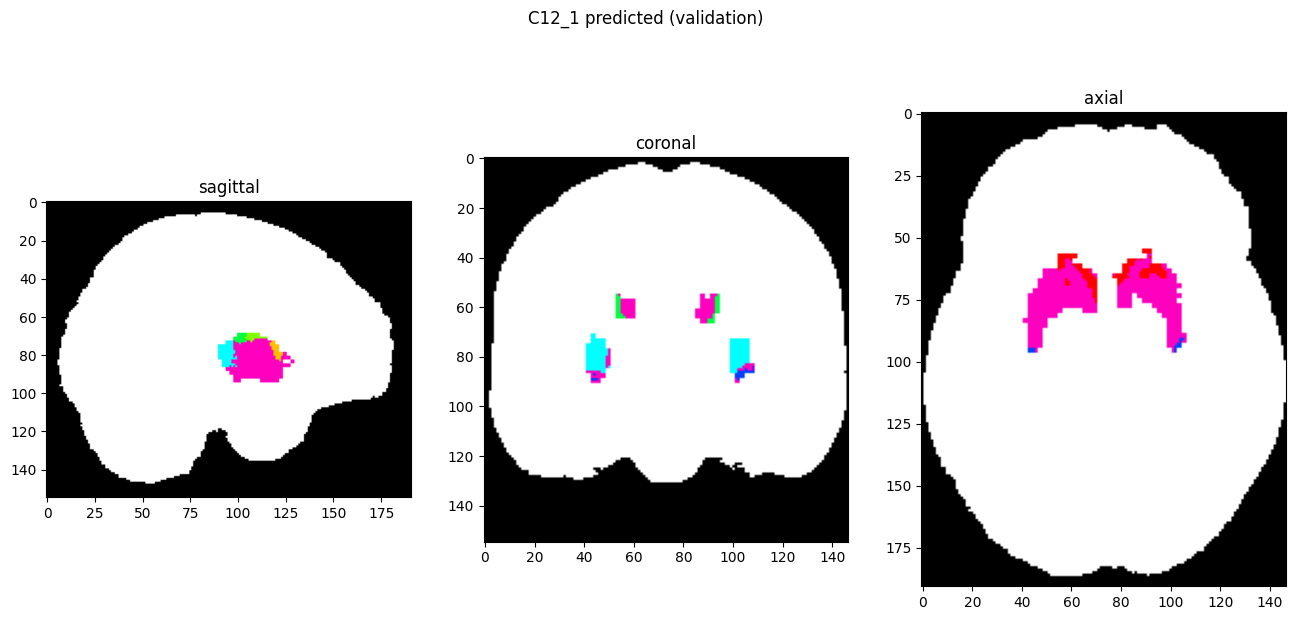

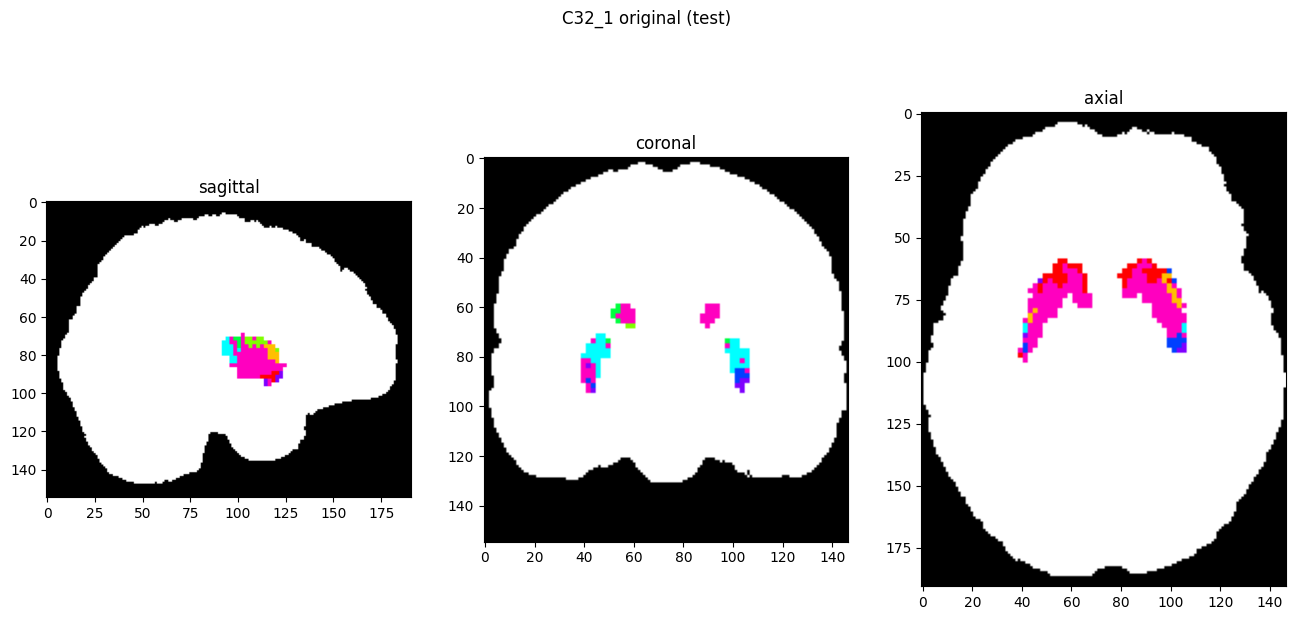

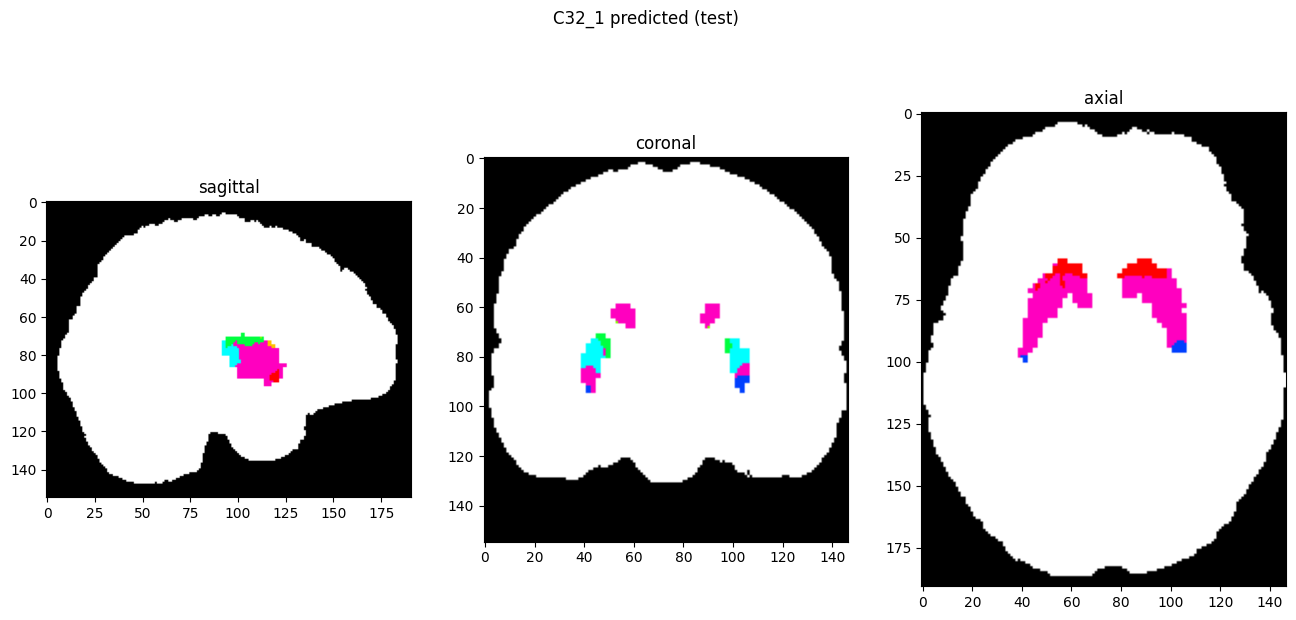

In [10]:
showResults(model, gen, threshold=0)